# Klassifizierung von menschlichen Emotionen mit einem Convolutional Neural Network unter Anwendung von TensorFlow


---
SoSe 2019  |  Dozent: B. Voigt | H. Rosales Musick (544360), J. Höhn (565265)

---

Das Notebook ist für den FER2013-Datensatz gebaut. Diesen kann man [hier](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge) herunterladen.

Es empfiehlt sich, das Notebook auf einem Leistungsstarken (GPU-)Server laufen zu lassen. Wie das gemacht werden kann, z. B. auf dem HTW-eigenen Server deepgreen03.f4.htw-berlin.de (um den Server zu nutzen muss man sich von Herrn [Kiewert](https://www.htw-berlin.de/hochschule/personen/person/?eid=2181) freischalten lassen), wir [hier](https://www.digitalocean.com/community/tutorials/how-to-install-run-connect-to-jupyter-notebook-on-remote-server) erklärt.

In [1]:
# needed imports
import keras
import numpy as np
import tensorflow as tf
from keras import Sequential, optimizers
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Activation
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.


---
Diese Klasse zeichnet nach jeder Epoche einen Graphen mit den Werten train_loss, train_acc, val_loss und val_acc.

[Quelle](https://medium.com/@kapilvarshney/how-to-plot-the-model-training-in-keras-using-custom-callback-function-and-using-tensorboard-41e4ce3cb401)

In [2]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

---
Hier wird der Datensatz eingelesen und für das Training vorbereitet.

[Quelle](https://github.com/serengil/tensorflow-101/blob/master/python/facial-expression-recognition.py)

In [3]:
# gpu configuration
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [4]:
# variables
num_classes = 7  # angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 128
epochs = 300
img_size = 48
learning_rate = 0.001
lr_decay = 0.0001

In [5]:
with open("fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ", num_of_instances)
print("instance length: ", len(lines[1].split(",")[1].split(" ")))

# initialize training set and test set
x_train, y_train, x_test, y_test = [], [], [], []

# transfer train and test set data
for i in range(1, num_of_instances):
    emotion, img, usage = lines[i].split(",")
    val = img.split(" ")
    pixels = np.array(val, 'float32')
    emotion = to_categorical(emotion, num_classes)
    if 'Training' in usage:
        y_train.append(emotion)
        x_train.append(pixels)
    elif 'PublicTest' in usage:
        y_test.append(emotion)
        x_test.append(pixels)

# data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

# normalize inputs between [0, 1]
x_train /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], img_size, img_size, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

number of instances:  35888
instance length:  2304
28709 train samples
3589 test samples


---
Data Augmentation - Die Bilder werden waagerecht gespiegelt

In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True)

---
Modell

In [13]:
model = Sequential()
# first conv layer (32 = number of feature maps, 3 x 3  filter size, use the "ReLU" activation function)
# input_shape: batch, width, height, dimensions


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, 1), name='First_Conv2D'))
#model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='2nd_Conv2D'))
model.add(BatchNormalization())
# first pooling layer
model.add(MaxPooling2D(pool_size=(2, 2), name='1st_Pooling'))
#model.add(Dropout(0.5))
#CCP
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name='3th_Conv2D'))
#model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name='4th_Conv2D'))
model.add(BatchNormalization())
# 2th pool
model.add(MaxPooling2D(pool_size=(2, 2), name='2nd_Pooling'))
#model.add(Dropout(0.5))
'''
# CCP
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='5th_Conv2D'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='6th_Conv2D'))
model.add(BatchNormalization())
# 3th pool
model.add(MaxPooling2D(pool_size=(2, 2), name='3nd_Pooling'))
model.add(Dropout(0.5))
# CCP
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='7th_Conv2D'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='8th_Conv2D'))
model.add(BatchNormalization())
# 4th pool
model.add(MaxPooling2D(pool_size=(2, 2), name='4th_Pooling'))
model.add(Dropout(0.5))
'''
# identification process
# flattening the outputs
model.add(Flatten())
# Fully Connected Layer
model.add(Dense(64, activation='relu', name='features1'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu', name='features2'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
# Classification
model.add(Dense(num_classes, activation='softmax'))

# show network architecture as formatted table
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First_Conv2D (Conv2D)        (None, 46, 46, 32)        320       
_________________________________________________________________
2nd_Conv2D (Conv2D)          (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
1st_Pooling (MaxPooling2D)   (None, 22, 22, 32)        0         
_________________________________________________________________
3th_Conv2D (Conv2D)          (None, 20, 20, 64)        18496     
_________________________________________________________________
4th_Conv2D (Conv2D)          (None, 18, 18, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 64)        256       
__________

In [14]:
# model compilation; use the cross entropy loss function and the optimizer function SGD or Adam
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9)
adam = optimizers.Adam(lr=learning_rate, decay=lr_decay, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

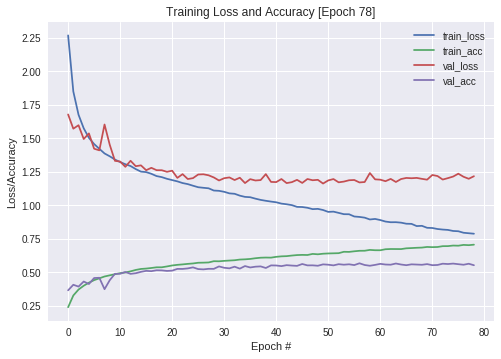

Epoch 80/300
 52/224 [=====>........................] - ETA: 3s - loss: 0.7740 - acc: 0.7156

In [ ]:
# training the model
'''
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                callbacks=[plot_losses])
'''
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(x_train) / batch_size,
                              epochs=epochs,
                              validation_data=(x_test, y_test),
                              callbacks=[plot_losses])
                             

---
Visualisierung
[Quelle](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

In [ ]:
# Visualization
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---
License Information: Please refer to READ.md